In [32]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [33]:
RESULTPATH = '/results/shapley/'
os.getcwd()

'/home/pkeyl/Projekte/Shapley/TCPA-Imputation'

In [34]:
filenames = os.listdir(os.getcwd() + RESULTPATH)

def load_file(filename):
    file_data = pd.read_csv(os.getcwd() + RESULTPATH + filename)
    target = filename.split('_')[3]
    file_data['target'] = target
    return file_data
data = pd.concat([load_file(filename) for filename in filenames])
data['target'] = data['target'].astype(int)
print(data)

data['shapley'].loc[data['masked_protein'] == data['target']] = 0

    masked_protein   shapley  target
0                0  0.121610       1
1                1  0.587616       1
2                2  0.208151       1
3                3  0.000021       1
4                4  0.000610       1
..             ...       ...     ...
2                2 -0.000839       6
3                3 -0.000169       6
4                4  0.102904       6
5                5  0.205127       6
6                6  0.608136       6

[70 rows x 3 columns]


/home/pkeyl/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [153]:
data_wide = pd.pivot_table(data, values = 'shapley', index='masked_protein',

                    columns='target')
#data_wide.values[[np.arange(data_wide.shape[0])]*2] = 0
#data_wide.values[[np.arange(13)]*2] = 0


<AxesSubplot:xlabel='target', ylabel='masked_protein'>

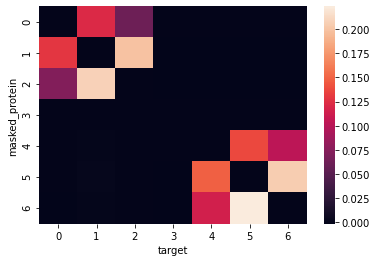

In [154]:
#sns.heatmap((data_wide>=0.001)*1.0)
sns.heatmap(data_wide)

In [155]:
#todo: ROC

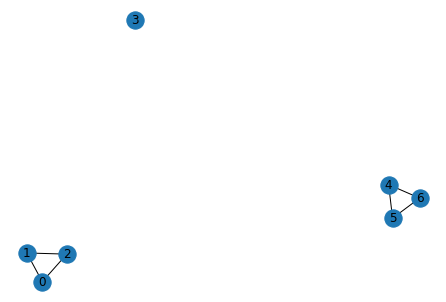

In [156]:
import networkx as nx
Graph = nx.from_numpy_matrix(np.array(data_wide>0.01))
nx.draw(Graph, with_labels=True)

In [157]:
#find triangles with networkx
import itertools
all_cliques= nx.enumerate_all_cliques(Graph)
triad_cliques=[x for x in all_cliques if len(x)==3 ]
a = triad_cliques[0]

def get_edges(triad_clique):
    duo_list = list(itertools.product(triad_clique, triad_clique))
    end_list = [a for a in duo_list if a[0]!= a[1]]
    return end_list

b = [get_edges(a) for a in triad_cliques]
edges =[item for sublist in b for item in sublist]
edges

[(0, 1),
 (0, 2),
 (1, 0),
 (1, 2),
 (2, 0),
 (2, 1),
 (4, 5),
 (4, 6),
 (5, 4),
 (5, 6),
 (6, 4),
 (6, 5)]

In [158]:
filenames = os.listdir(os.getcwd() + '/results/triangle/')

def load_file(filename):
    file_data = pd.read_csv(os.getcwd() + '/results/triangle/' + filename)
    source = filename.split('_')[3]
    condition = filename.split('_')[4]
    file_data['source'] = source
    file_data['condition'] = condition
    return file_data
cond_data = pd.concat([load_file(filename) for filename in filenames])
cond_data['source'] = cond_data['source'].astype(int)
cond_data['masked_protein'] = cond_data['masked_protein'].astype(int)
cond_data['condition'] = cond_data['condition'].astype(int)



[(6, 5), (6, 6), (2, 2), (0, 0), (0, 1), (0, 0), (6, 4), (6, 6), (2, 1), (2, 2), (5, 5), (5, 6), (5, 4), (5, 5), (4, 4), (4, 6), (1, 0), (1, 1), (1, 5), (4, 4), (4, 5), (1, 1), (1, 2), (1, 5)]


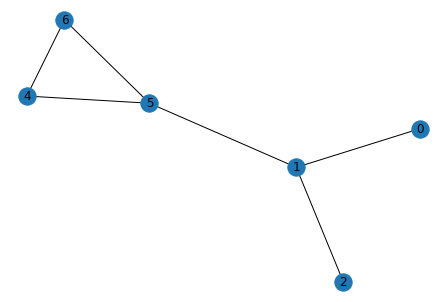

In [159]:
sources = cond_data['source'].max()
#edge_list = #{i:{cond_data['source'].iloc[i]: cond_data['masked_protein'].iloc[i]} for i in range(sources)}

cond_data2 = cond_data[cond_data['shapley']>0.001]
edge_list = (list(zip(list(cond_data2['source']),list(cond_data2['masked_protein']))))
print(edge_list)
cond_graph = nx.from_edgelist(edge_list)
nx.draw(cond_graph, with_labels=True)

2.0 0.0


/home/pkeyl/.local/lib/python3.6/site-packages/pandas/core/frame.py:4304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


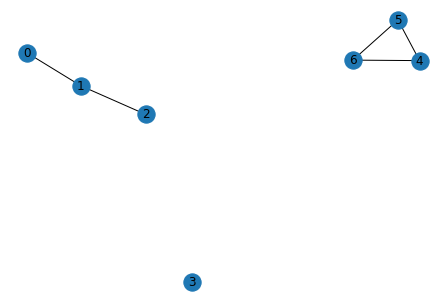

In [174]:
def get_triplets(triad_clique):
    raw_triplets = list(itertools.product(triad_clique, triad_clique, triad_clique))
    triplet_list = [raw_triplet for raw_triplet in raw_triplets if len(set(raw_triplet))==len(raw_triplet)]
    return triplet_list

triplets = [get_triplets(triad_clique) for triad_clique in triad_cliques]

def get_data(triplet):
    data = cond_data.loc[(cond_data['masked_protein']== triplet[0]) & (cond_data['source']== triplet[1]) & 
                   (cond_data['condition']== triplet[2])]
    return data

cond_values = pd.concat([get_data(triplet) for sublist in triplets for triplet in sublist])

cond_values_dir = cond_values.loc[cond_values['masked_protein']> cond_values['source']]
cond_values_trans = cond_values.loc[cond_values['masked_protein']< cond_values['source']]
cond_values_trans.rename(columns= {'masked_protein':'source', 'source': 'masked_protein'}, inplace = True)

merged_values = pd.merge(cond_values_dir, cond_values_trans, on = ('masked_protein', 'source', 'condition'))
merged_values['shapley'] = 0.5 * (merged_values['shapley_x'] + merged_values['shapley_y'])

del_edges = merged_values[merged_values['shapley']<0.005]
corrected_graph = Graph.copy()

for i in range(del_edges.shape[0]):
    print(del_edges.iloc[i]['masked_protein'], del_edges.iloc[i]['source'])
    corrected_graph.remove_edge(del_edges.iloc[i]['source'], del_edges.iloc[i]['masked_protein'])

nx.draw(corrected_graph, with_labels=True)


/home/pkeyl/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:>

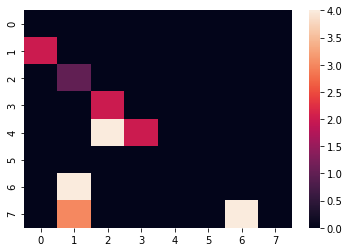

In [17]:
# for asymmetric data
func_mat = pd.read_csv(os.getcwd() + '/results/adjacency/function.csv', header=None)
func_mat.values[[np.arange(func_mat.shape[0])]*2] = 0
func_mat.shape
sns.heatmap(np.abs(func_mat))

In [249]:
func_mat_ = func_mat.copy()
func_mat_['p'] = func_mat_.index
func_long = pd.melt(func_mat_, id_vars=['p'], var_name='q')

In [250]:
data.rename(columns = {'masked_protein': 'p', 'target': 'q'}, inplace=True)
new_data = pd.merge(data, func_long, how = 'left', left_on =['p', 'q'], right_on = ['p', 'q'])
new_data_filtered = new_data[new_data['p']!=new_data['q']]
new_data_filtered.loc[:,'value'] = np.abs(new_data_filtered['value'])
new_data_filtered.loc[:,'interaction'] = (new_data_filtered['value']!=0)*1.0
#new_data_filtered= new_data_filtered[(new_data_filtered['value']==0) | (new_data_filtered['value']>0.005)]

/home/pkeyl/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/home/pkeyl/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/pkeyl/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

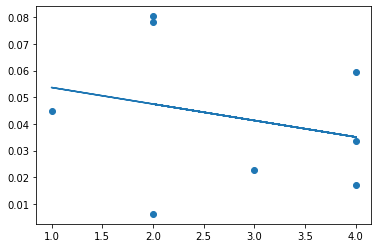

In [251]:
for_plot = new_data_filtered[new_data_filtered['interaction']==1]
plt.scatter(for_plot['value'], for_plot['shapley'])
m, b = np.polyfit(for_plot['value'], for_plot['shapley'], 1)
plt.plot(for_plot['value'], m*for_plot['value'] + b)

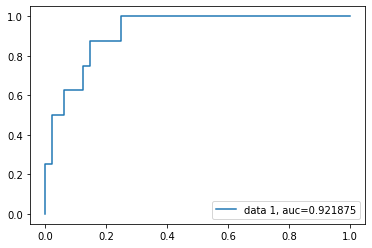

In [252]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt

y_test = new_data_filtered['interaction']
y_pred_proba = new_data_filtered['shapley']


fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [253]:
function_mat = pd.read_csv('/home/pgk/PycharmProjects/Proteomics/TCPA-Imputation/results/shapley/adjacency/function.csv', header=None)
function_mat.values[[np.arange(func_mat.shape[0])]*2] = 0

FileNotFoundError: [Errno 2] No such file or directory: '/home/pgk/PycharmProjects/Proteomics/TCPA-Imputation/results/shapley/adjacency/function.csv'

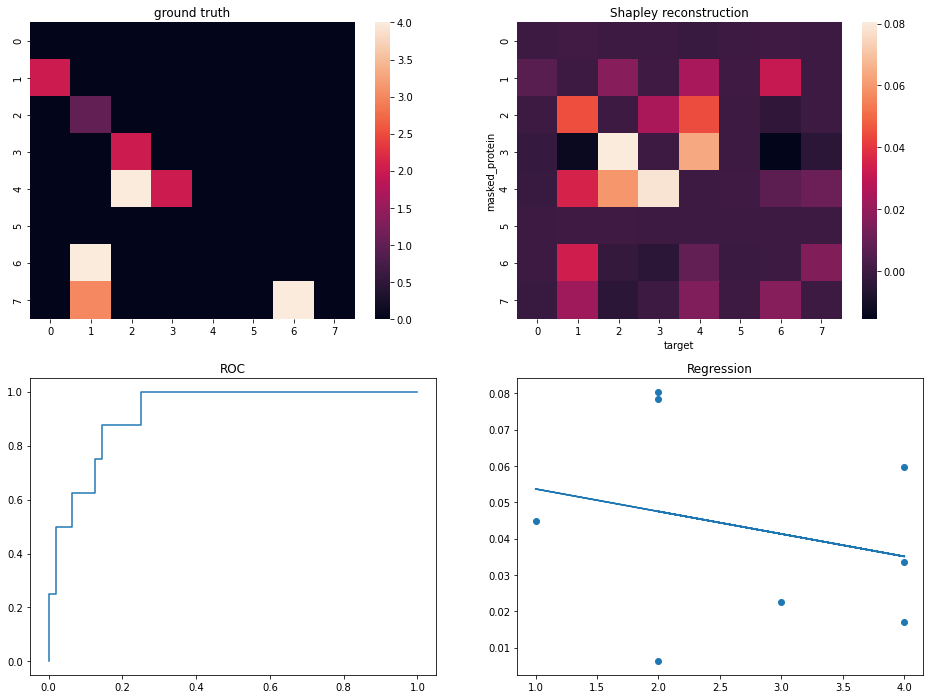

In [254]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(16, 12))
sns.heatmap(np.abs(func_mat), ax = ax1)
ax1.set_title('ground truth')
sns.heatmap(data_wide, ax=ax2)
ax2.set_title("Shapley reconstruction")
ax3.plot(fpr,tpr,label="data 1, auc="+str(auc))
ax3.set_title("ROC")
ax4.scatter(for_plot['value'], for_plot['shapley'])
ax4.plot(for_plot['value'], m*for_plot['value'] + b)
ax4.set_title("Regression")
plt.savefig('results/figures/shapley_reconstruction.png')

<AxesSubplot:>

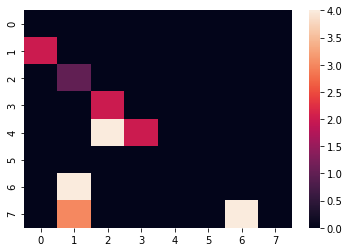

In [241]:
sns.heatmap(np.abs(func_mat))

In [250]:
dataframe = np.loadtxt('results/data/data.csv', delimiter=',').transpose()
dataframe.shape
correlation = np.corrcoef(dataframe)
np.fill_diagonal(correlation, 0)

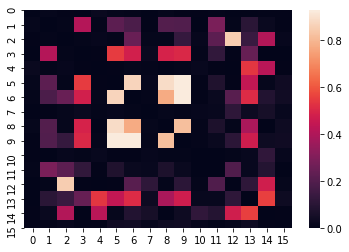

In [251]:
sns.heatmap(np.abs(correlation))